In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn.functional as F
import seaborn as sn
from sklearn.metrics import confusion_matrix
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# Settings
numEpochs = 5 # Number of training rounds. More = greater accuracy, longer training
testAccuracyWhenTraining = False # Runs testing after each training iteration, outputs accuracy plot at the end. Takes longer.
useFullSet = False # If false, uses the 'balanced' training set (smaller, and not all digits), thus trains faster

# ByClass
if(useFullSet):   
    trainset = datasets.EMNIST(root='./data', download=True, train=True, split='byclass', transform=transform)
    valset = datasets.EMNIST(root='./data', download=True, train=False, split='byclass', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)
    
    numOutFeatures = 62
    charList = ['0','1','2','3','4','5','6','7','8','9',
            'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
            'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    
# Balanced
else:
    trainset = datasets.EMNIST(root='./data', download=True, train=True, split='balanced', transform=transform)
    valset = datasets.EMNIST(root='./data', download=True, train=False, split='balanced', transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

    numOutFeatures = 47
    charList = ['0','1','2','3','4','5','6','7','8','9',
                'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
                'a','b','d','e','f','g','h','n','q','r','t']  

In [4]:
# Model replicated from
# https://web.stanford.edu/class/cs231m/projects/final-report-yang-pu.pdf

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=1, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=1, dilation=1)

        self.fc1 = nn.Linear(16*5*5, 128)
        self.fc2 = nn.Linear(128, numOutFeatures)

    def forward(self, x):
        #batch_size = x.size(0)
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 16*5*5) # resize for the FC      
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Create the model
model = Net()

# Define the optimizer and loss criteria
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
criterion = nn.CrossEntropyLoss()

# Use GPU if available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
# Display the model
model.eval()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

In [6]:
def testAccuracy():
    correct_count, all_count = 0, 0

    for images,labels in testloader:
      for i in range(len(labels)):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        img = images[i].view(1, 1, 28, 28)

        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))

        # Increment the counts
        true_label = labels.cpu()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

    return(correct_count/all_count)

In [7]:
time0 = time()
epochs = numEpochs
epochNum, epochLoss, epochAccuracy = [], [], []
for i in range(epochs):
    train_loss = 0
    for images, labels in trainloader:

        # Use GPU if abailable
        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Training pass
        optimizer.zero_grad()       
        output = model(images)
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Optimize weights
        optimizer.step()
        
        train_loss += loss.item()
    else:
        epochNum.append(i)
        epochLoss.append(train_loss/len(trainloader))        
        print("Epoch {} - Training loss: {}".format(i, train_loss/len(trainloader))) # Average over each image in the training set for each epoch
        
        # Test the accuracy
        if(testAccuracyWhenTraining):
            accuracy = testAccuracy() 
            epochAccuracy.append(accuracy)
            print("\tAccuracy: ", accuracy) # Calculate the arruacy for the current epoch
        
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.8118542721848967
Epoch 1 - Training loss: 0.4220972887989951
Epoch 2 - Training loss: 0.37015434955914994
Epoch 3 - Training loss: 0.34232273181426004
Epoch 4 - Training loss: 0.3215667378670846

Training Time (in minutes) = 1.943850866953532


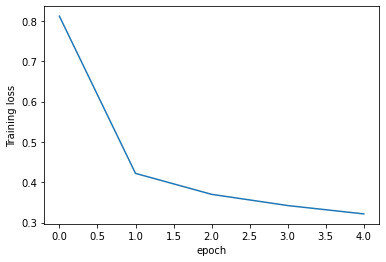

In [9]:
# Training loss
plt.figure(0)
plt.plot(epochNum, epochLoss)
plt.xlabel('epoch')
plt.ylabel('Training loss')

# Accuracy
if(testAccuracyWhenTraining):
    plt.figure(1)
    plt.plot(epochNum, epochAccuracy)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

In [10]:
# getting predictions on test set and measuring the performance
correct_count, all_count, totalPredTime = 0, 0, 0
predictions, targets = [], []

for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 1, 28, 28)
    
    # Prediction start
    timepred0 = time()    
    with torch.no_grad():
        logps = model(img)
    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    totalPredTime += (time() - timepred0)
    # Prediction end
    
    # Increment the counts
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1
    
    # Add to the list of predictions
    predictions.append(pred_label)
    targets.append(true_label)

print("Images Tested: ", all_count)
print("Accuracy: ", (correct_count/all_count))
print("Average computational time (ms): ", 1000*totalPredTime/all_count)

Images Tested:  18800
Accuracy:  0.8667021276595744
Average computational time (ms):  1.3732159264544224


Text(69.0, 0.5, 'True label')

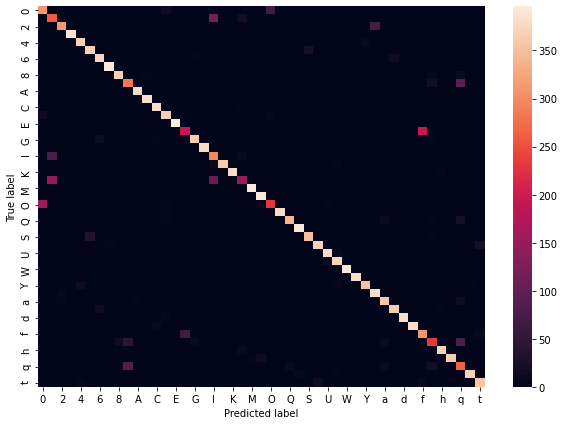

In [11]:
# Create the character dictionary
charDict = {v: k for v, k in enumerate(charList)}

# Convert the tensor list into a list of ints
targetsList = []
for i in targets:
    targetsList.append(i.item())

# Transform the labels to their respective characters
predictionLabels = [charDict[x] for x in predictions]
trueLabels = [charDict[x] for x in targetsList]

# Convert it into a pandas dataframe
targPredListLabels = pd.DataFrame(
    {'targets': trueLabels,
     'predictions': predictionLabels
    })

# Create the confusions matrix
cm = pd.crosstab(targPredListLabels['targets'], targPredListLabels['predictions'])

# Plot the confusion matrix
plt.figure(figsize = (10,7))
sn.heatmap(cm, fmt="d")
plt.xlabel('Predicted label')
plt.ylabel('True label')